In [3]:
from keras.datasets import cifar10
from keras.layers import Input, Dense,Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization
from keras.models import Model,Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

(X_train, _), (X_test, _) = cifar10.load_data()
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_train = X_train.reshape(len(X_train),X_train.shape[1],X_train.shape[2],3)
X_test = X_test.reshape(len(X_test), X_test.shape[1],X_test.shape[2],3)
print(X_train.shape)
print(X_test.shape)


170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


# Simple Initial Dense Layer

For our initial approach, we will create an encoder that encompasses only a single Dense layer of 32 neurons for our encoder and a decoder with only 
3 neurons for our output (3 are needed for the cifar10 dataset).

The initial dimension of the first layer for the encoder on the input image represents the compression factor on the given image.

In [ ]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 96, assuming the input is 32 * 32 * 3 floats

# This is our input image
input_img = keras.Input(shape=(32,32,3))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(3, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))



Epoch 1/10
196/196 [==============================] - 24s 122ms/step - loss: 0.6135 - val_loss: 0.5725
Epoch 2/10
196/196 [==============================] - 33s 167ms/step - loss: 0.5635 - val_loss: 0.5593
Epoch 3/10
196/196 [==============================] - 23s 115ms/step - loss: 0.5549 - val_loss: 0.5531
Epoch 4/10
196/196 [==============================] - 20s 103ms/step - loss: 0.5516 - val_loss: 0.5520
Epoch 5/10
196/196 [==============================] - 24s 120ms/step - loss: 0.5510 - val_loss: 0.5517
Epoch 6/10
196/196 [==============================] - 23s 120ms/step - loss: 0.5508 - val_loss: 0.5516
Epoch 7/10
196/196 [==============================] - 26s 133ms/step - loss: 0.5508 - val_loss: 0.5516
Epoch 8/10
196/196 [==============================] - 29s 149ms/step - loss: 0.5508 - val_loss: 0.5516
Epoch 9/10
196/196 [==============================] - 23s 117ms/step - loss: 0.5507 - val_loss: 0.5516
Epoch 10/10
196/196 [==============================] - 26s 131ms/step - l

After encoding the dataset, we can now decode some images to predict the result on the testing part.

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 4ms/step


313/313 [==============================] - 1s 4ms/step


Below we will attempt to represent some of said images

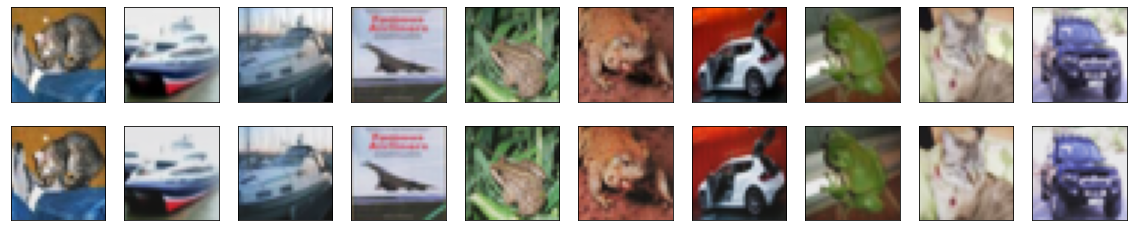

In [ ]:
# Use Matplotlib
import matplotlib.pyplot as plt

n = 10  # Number of images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can obviously observe on the 2nd row (decoded images) the difference with the originals. 

The reconstruction is succesful in predicting and representing the original image well enough, but we can easily notice noise prblems.

# DENSE LAYERS WITH MORE NEURONS EXPERIMENT

For this experiment will implement an autoencoder using only simple dense layers.

We will input a lot of neurons (128,64 and 128 respectively) to attempt to achieve better results.

This of course will increase the time taken for each epoch so we will only attempt to run it for 4 epochs to see the tendency of the results.

It is obvious that as far as there is no overtraining, the accuracy will continue to increase, albeit in smaller increments with the incrementation of the epochs and the loss will continue decreasing.

In [ ]:
# Create the model
input_layer = Input(shape=(32, 32, 3))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(3, activation='sigmoid')(decoded)

# Compile the model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
autoencoder.fit(X_train, X_train, epochs=4, batch_size=256, validation_data=(X_test, X_test))

# Encode and decode some images
encoder = Model(input_layer, encoded)
encoded_images = encoder.predict(X_test)
decoded_images = autoencoder.predict(X_test)


Epoch 1/4
196/196 [==============================] - 241s 1s/step - loss: 0.5726 - val_loss: 0.5508
Epoch 2/4
196/196 [==============================] - 216s 1s/step - loss: 0.5489 - val_loss: 0.5492
Epoch 3/4
196/196 [==============================] - 237s 1s/step - loss: 0.5479 - val_loss: 0.5486
Epoch 4/4
313/313 [==============================] - 10s 31ms/step


After predicting some images above, we will now output them below for comparison

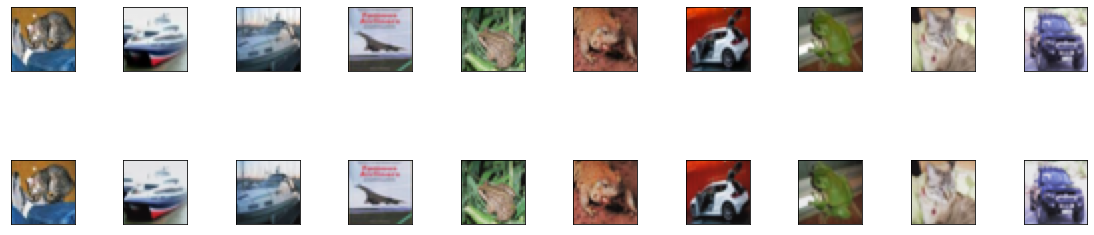

In [ ]:
from matplotlib import pyplot
plt.figure(figsize=(40,4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_test[i].reshape(32, 32, 3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(decoded_images[i].reshape(32, 32, 3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

It is clear that there is some pixelation and noise in general in the images above on the 2nd row (decoded images), but they are pretty close in general to the initial image.

# CONV2D EXPERIMENT

For this experiment, we will pass the encoder through a convolution 2D layer instead of a simple dense layer.

We will leave the kernel on a 3x3 frame instead of a 2x2 like the last projects to ensure a bit faster results. We will also add an dditional layer on both the encoder and the decoder to attempt to achieve better results.

In [ ]:
input_img = Input(shape=(32,32,3))

#Encoder
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

#Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

Instead of running it directly, we will process the dataset through a convolution 2D neural network model to ensure even better results. We will add 3 hidden layers with low neuron count on each to ensure comlexity yet make them faster for time purposes.

It is evident that increasing the hidden layers and/or the neuron count will yield better results in the long run but will drastically increase eexceution time.

We could use sparse catgorical accuracy for the loss like the previous projects but we will attempt to use mean squared error this time as a different approach.

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())     # 32x32x32
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
model.add(BatchNormalization())     # 16x16x32
model.add(UpSampling2D())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
model.add(BatchNormalization())
model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
# model.summary()

We will now pass the autoencoder as well as the encoder through the model and compile it.

In [ ]:
autoencoder=Model(input_img, decoded)

# autoencoder.summary()

encoder = Model(input_img, encoded)

# encoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

We will now run the training and validation process. We will save it for use on its history on graphs later.

We will only attempt 4 epochs as previously because each iteration takes a lot of time.

Batch size will remain at 256, albeit there is no difference above 32 on the system in which the experiment was run. This can change accordingly to select devices.

In [ ]:
history = model.fit(X_train, X_train,
                epochs=4,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/4
196/196 [==============================] - 257s 1s/step - loss: 6.8408e-04 - accuracy: 0.8400 - val_loss: 6.0175e-04 - val_accuracy: 0.8418
Epoch 2/4
196/196 [==============================] - 257s 1s/step - loss: 5.9713e-04 - accuracy: 0.8497 - val_loss: 6.4952e-04 - val_accuracy: 0.8551
Epoch 3/4
196/196 [==============================] - 255s 1s/step - loss: 5.2646e-04 - accuracy: 0.8568 - val_loss: 7.1080e-04 - val_accuracy: 0.8528
Epoch 4/4
196/196 [==============================] - 262s 1s/step - loss: 4.9200e-04 - accuracy: 0.8626 - val_loss: 4.3757e-04 - val_accuracy: 0.8538


Each epoch takes about 4 and a half minutes (256 seconds average). With more iterations, the accuracy should increase in the long run and the loss will decrease (as shown in previous projects).

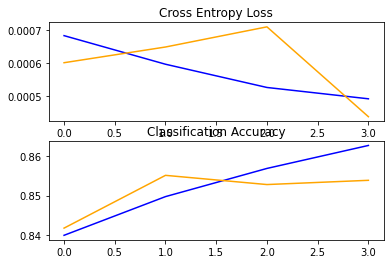

In [ ]:
# plot loss
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')

# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

pyplot.show()
pyplot.close()

We will now run and save a precistion test on the model and show said results.

In [ ]:
#encoded_imgs = model.predict(X_test)
predicted = decoder.predict(X_test)

313/313 [==============================] - 13s 42ms/step


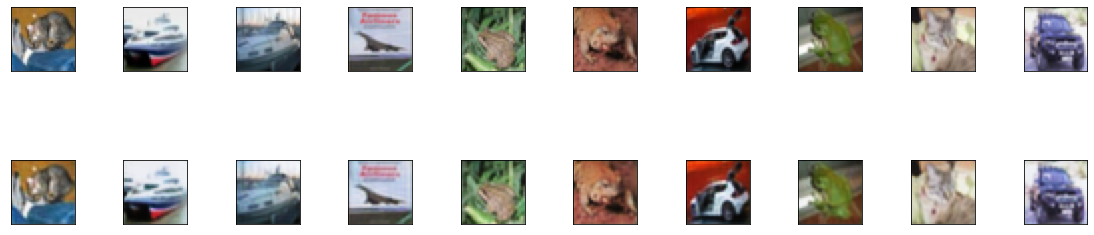

In [ ]:


plt.figure(figsize=(40,4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_test[i].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

# kNN and Nearest Centroid Experiment

As with previous projects, we will run the Cifar10 dataset on the above classifiers to compare results with the autoencoder

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

We will reload the dataset to include the labels this time as well.

We will also reshape the data for usage in the classifiers.

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape)
print(x_test.shape)

x_train_trans = X_train.reshape(50000, 3072)
x_test_trans = X_test.reshape(10000, 3072)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


# kNN with 1 neighbour

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(x_train_trans, y_train)
print("Test accuracy = ", knn1.score(x_test_trans,y_test))

Test accuracy =  0.3539


The test accuracy is pretty low, yet quite fast. As expected.

# kNN with 3 neighbours

In [ ]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(x_train_trans, y_train)
print("Test accuracy = ", knn3.score(x_test_trans,y_test))

Test accuracy =  0.3303


The test accuracy is pretty low, and also worse that the kNN with 1 neighbours, as expected.

# Nearest Centroid

In [ ]:
ctr = NearestCentroid()
ctr.fit(x_train_trans, y_train)
NearestCentroid()
print("Test accuracy = ", ctr.score(x_test_trans,y_test))


Test accuracy =  0.2774


The test accuracy is the lowest yet, but the fastest one by far, as expected

# PCA Reconstruction

First we will flatten the images for faster training

In [6]:
#flatten images
x_train_flat = x_train.reshape(-1,3072)
x_test_flat = x_test.reshape(-1, 3072)

Next we will display the number of components needed for a 90% fit as well as fit the dataset on the pca

In [9]:
from sklearn.decomposition import PCA
pca = PCA(0.90)
pca.fit(x_train_flat)
PCA(copy = True, iterated_power = 'auto', n_components = 0.90, random_state = None, svd_solver = 'auto', tol = 0.0, whiten = False)
pca.n_components_

99

We will need 99 components for a 90% fit

We will transform the pca for the flat train and test dataset as well as transform the labels for easier usage

In [10]:
from keras.utils import np_utils
train_img_pca = pca.transform(x_train_flat)
test_img_pca = pca.transform(x_test_flat)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [11]:
batch_size = 128
num_classes = 10
epochs = 50

We will create a simple neuron network with dense layers and high neuron count for the pca

In [18]:
#define Sequential model
model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape = (99,))) #Given by the above dimension test
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

#model.summary()

We will run the model and see the results. It is quite fast since we reduced the dimensions quite a bit

In [19]:
#compile and train the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

history = model.fit(train_img_pca,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (test_img_pca, y_test))

Epoch 1/50
391/391 [==============================] - 2s 5ms/step - loss: 6.0249 - accuracy: 0.1052 - val_loss: 2.3066 - val_accuracy: 0.1010
Epoch 2/50
391/391 [==============================] - 2s 5ms/step - loss: 2.2999 - accuracy: 0.0988 - val_loss: 2.2968 - val_accuracy: 0.1079
Epoch 3/50
391/391 [==============================] - 2s 4ms/step - loss: 2.2857 - accuracy: 0.1129 - val_loss: 2.2792 - val_accuracy: 0.1178
Epoch 4/50
391/391 [==============================] - 2s 4ms/step - loss: 2.2479 - accuracy: 0.1396 - val_loss: 2.2167 - val_accuracy: 0.1554
Epoch 5/50
391/391 [==============================] - 2s 4ms/step - loss: 2.1848 - accuracy: 0.1673 - val_loss: 2.1570 - val_accuracy: 0.1872
Epoch 6/50
391/391 [==============================] - 2s 5ms/step - loss: 2.1072 - accuracy: 0.1916 - val_loss: 2.0726 - val_accuracy: 0.2162
Epoch 7/50
391/391 [==============================] - 2s 5ms/step - loss: 2.0118 - accuracy: 0.2182 - val_loss: 1.9734 - val_accuracy: 0.2337
Epoch 

We can visualize the results

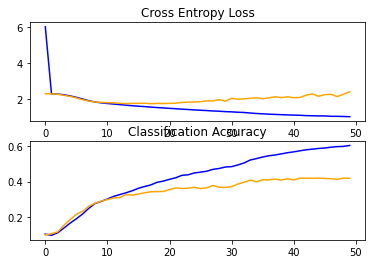

In [39]:
# plot loss
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
pyplot.show()
pyplot.close()

Obviously, for hifher neuron count and more layers the process yields better results, but we will remain on these results for faster implemenation and simpler comparison

# RESULT COMPARISON

**Note: Some results only have accuracy or loss for comparison**

Simple Dense Autoencoder :

loss: **0.5507** - val_loss: **0.5516**


High Neuron Count Dense Autoencoder :

loss: **0.5476** - val_loss: **0.5484**

Conv2D with High Neuron Count Autoencoder :

loss: **4.9200e-04** - accuracy: **0.8626** - val_loss: **4.3757e-04** - val_accuracy: **0.8538**

PCA with 99 dimensions

loss: **1.0278** - accuracy: **0.6032** - val_loss: **2.4188** - val_accuracy: **0.4187**

kNN with 1 neighbour :

accuracy: **0.3539**

kNN with 3 neighbours :

accuracy: **0.3303**

Nearest Centroid :

accuracy: **0.2774**

Although we can obviously increase the accuracy of the PCA, it will need a lot of epochs and neuron count as well as layers to reach the accuracy of Conv 2D.

# Conclusion

As it is evident from the above results, although autoencoder does not really have a good use and yields mediocre results for niche usages, it can yield very good accuracies and very low loss when implementing a complex and big neural network model as well as a lot of layers with high neuron count.

Overall, Conv 2D layers with MaxPooling and Upsampling as well as high neuron count yield the best results even in low epochs.